In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# 4.1.3 Least Squares for Classification

Let's say we have $K=2$ classes, each coming from some Gaussian distribution. And let's say the points being classified are coming from $D=2$ dimensional space.

[0.92956878 0.96386427] [0.14330237 0.67944719]


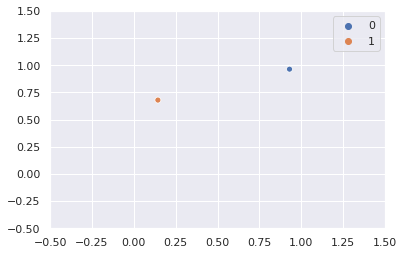

In [2]:
# Choose from the unit square means for three gaussians
while True:
    mu1 = np.random.uniform(0,1,2)
    mu2 = np.random.uniform(0,1,2)
    if np.linalg.norm(mu1-mu2) >= 0.6:
        break
    
means = np.array([mu1,mu2])
ax = sns.scatterplot(x = means.transpose()[0], y = means.transpose()[1],hue=[0,1]);
def set_bounds(ax):
    ax.set_xbound(-0.5,1.5)
    ax.set_ybound(-0.5,1.5)
set_bounds(ax)
print(mu1,mu2)

This is kind of a sidetrack, but here is a neat way to choose a random covariance matrix:

In [3]:
def random_cov_matrix(n):
    """Sample an nxn positive definite matrix.
    Return it, along with the 'Ainv' that generated it."""
    A = np.linalg.inv(np.random.multivariate_normal(np.zeros(n),100*np.identity(n),n).transpose())
    return A.transpose() @ A, A

This idea is that a covariance matrix is a positive definite symmetric matrix, and here is something one can show:

_Every positive definite symmetric $n\times n$ matrix is $A^TA$ for some nonsingular $n\times n$ matrix A. The columns of $A^{-1}$ form a basis in which the bilinear form $A^TA$ is orthogonal, and in fact is represented by an identity matrix._

So we use a gaussian centered at the origin to sample a pair of vectors to serve as the columns of $A^{-1}$, and then $A^TA$ is our covariance matrix. Here's the shape we get:

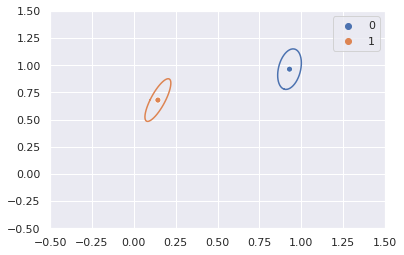

In [4]:
# choose two random covariance matrices
cov1, A1 = random_cov_matrix(2)
cov2, A2 = random_cov_matrix(2)

# plot dots for the means again
ax = sns.scatterplot(x = means.transpose()[0], y = means.transpose()[1],hue=[0,1])

# display a contour of the gaussians with parameters mu1, cov1 and mu2, cov2
r = 1
theta = np.linspace(0,2*np.pi)
x1_circ = r * np.array(list(map(np.cos,theta)))
x2_circ = r * np.array(list(map(np.sin,theta)))
ellipse1 = (A1.transpose() @ np.array([x1_circ,x2_circ]))
ellipse2 = (A2.transpose() @ np.array([x1_circ,x2_circ]))
ax.plot(ellipse1[0]+mu1[0],ellipse1[1]+mu1[1])
ax.plot(ellipse2[0]+mu2[0],ellipse2[1]+mu2[1])
set_bounds(ax)

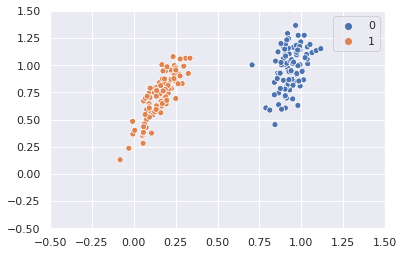

In [5]:
# Generate some data from those distributions:

num_points = 100
data1 = np.random.multivariate_normal(mu1,cov1,size=num_points)
data2 = np.random.multivariate_normal(mu2,cov2,size=num_points)
data_all = np.concatenate((data1,data2))
color_data = np.concatenate((np.repeat(0,num_points),np.repeat(1,num_points)))
ax = sns.scatterplot(x   = data_all.transpose()[0],
                     y   = data_all.transpose()[1],
                     hue = color_data)
set_bounds(ax)

Finally, we apply the least squares method described in the text to find the optimal parameter matrix $W$:

In [6]:
X = np.concatenate((np.ones(2*num_points).reshape(-1,1),data_all),axis=1) # This is \tilde{X} from text
T = np.repeat([[1,0],[0,1]],[num_points,num_points],axis=0)

W = np.linalg.solve(X.transpose() @ X, X.transpose() @ T)

The decision boundary will be the set of points $(x_1,x_2)$ for which $[x_1\,x_2]W$ has its first and second components being equal. In other words it's the preimage of the hyperplane $y_1=y_2$ under the mapping $(x_1,x_2)\mapsto (y_1,y_2) = [x_1\,x_2]W$. Since linear constraints of $T$ are preserved by predictions (see bottom half of p185), we know that the sum of the entries of $[x_1\,x_2]W$ will be $1$. Therefore the decision boundary will be the set of points for which $[x_1\,x_2]W$ has, say, its first component being $\frac{1}{2}$.

Using this idea we can plot the decision boundary:

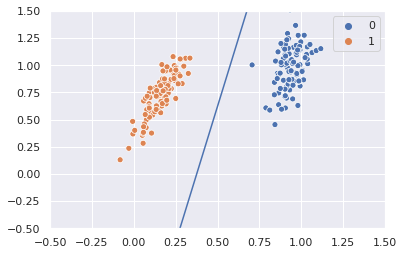

In [7]:
w01,w11,w21 = W[:,0]
decision_bdry_x1_to_x2 = lambda x1 : (0.5-w01-x1*w11)/w21
x1s = [-2,2]
ax = sns.lineplot(x = x1s,y=list(map(decision_bdry_x1_to_x2,x1s)))
ax = sns.scatterplot(x   = data_all.transpose()[0],
                     y   = data_all.transpose()[1],
                     hue = color_data)
set_bounds(ax)

## Issue with outliers

Great, but there is a problem with this method of classification.

The sum-of-squares error function penalizes results that are "too correct" in that the decision boundary is too far away in the correct direction. This causes the least squares method to be very poor at handling outliers. Let's create some outlying data that we think should not cause the decision boundary to move:

In [8]:
# The point [0.5,decision_bdry_x1_to_x2(0.5)] is on the decision bdry about halfway along
# The vector W[1:,0] is orthogonal to the decision bdry
a_very_blue_place = [0.5,decision_bdry_x1_to_x2(0.5)] + 10*W[1:,0]

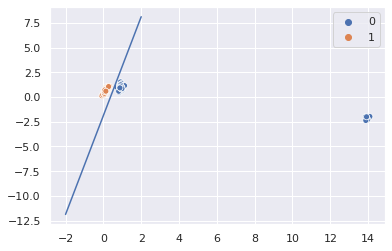

In [9]:
num_new_pts = 10
new_pts = np.random.multivariate_normal(a_very_blue_place,0.02*np.identity(2),num_new_pts)
data_with_new = np.concatenate((data_all,new_pts))
color_data_with_new = np.concatenate((color_data,np.repeat(0,num_new_pts)))

ax = sns.lineplot(x = x1s,y=list(map(decision_bdry_x1_to_x2,x1s)))
ax = sns.scatterplot(x   = data_with_new.transpose()[0],
                     y   = data_with_new.transpose()[1],
                     hue = color_data_with_new)

Now let's relearn the parameter matrix $W$ and look at what happens to the decision boundary:

In [10]:
X = np.concatenate((np.ones(2*num_points+num_new_pts).reshape(-1,1),data_with_new),axis=1)
T = np.repeat([[1,0],[0,1],[1,0]],[num_points,num_points,num_new_pts],axis=0)

W = np.linalg.solve(X.transpose() @ X, X.transpose() @ T)

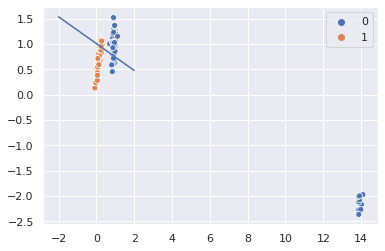

In [11]:
w01,w11,w21 = W[:,0]
ax = sns.lineplot(x = x1s,y=list(map(decision_bdry_x1_to_x2,x1s)))
ax = sns.scatterplot(x   = data_with_new.transpose()[0],
                     y   = data_with_new.transpose()[1],
                     hue = color_data_with_new)

The decision boundary should be affected by these few additional points, and often when you run this code (though not every time) it will be a lot worse than if it did not change at all!

## Three classes

[0.9544764  0.97797671] [0.46115553 0.12317322] [0.53131065 0.53767491]


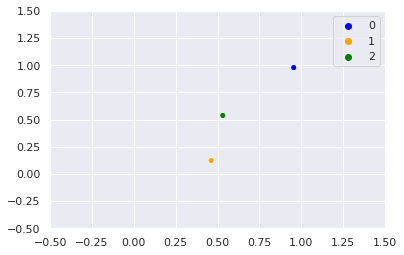

In [21]:
# Choose from the unit square means for three gaussians
while True:
    mu1 = np.random.uniform(0,1,2)
    mu2 = np.random.uniform(0,1,2)
    mu3 = np.random.uniform(0,1,2)
    if min(np.linalg.norm(mu1-mu2),
           np.linalg.norm(mu2-mu3),
           np.linalg.norm(mu3-mu1)) >= 0.4:
        break
    
means = np.array([mu1,mu2,mu3])
palette = ["blue","orange","green"]
ax = sns.scatterplot(x = means.transpose()[0], y = means.transpose()[1],hue=[0,1,2],palette=palette);
set_bounds(ax)
print(mu1,mu2,mu3)

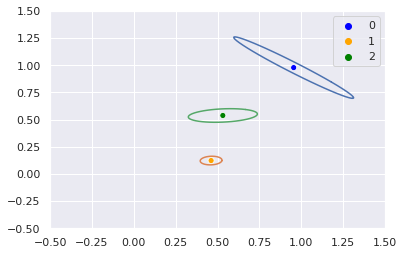

In [24]:
# choose three random covariance matrices
cov1, A1 = random_cov_matrix(2)
cov2, A2 = random_cov_matrix(2)
cov3, A3 = random_cov_matrix(2)

# plot dots for the means again
ax = sns.scatterplot(x = means.transpose()[0], y = means.transpose()[1],hue=[0,1,2],palette=palette)

# display a contour of the gaussians with parameters mu1, cov1 and mu2, cov2
r = 1
theta = np.linspace(0,2*np.pi)
x1_circ = r * np.array(list(map(np.cos,theta)))
x2_circ = r * np.array(list(map(np.sin,theta)))
ellipse1 = (A1.transpose() @ np.array([x1_circ,x2_circ]))
ellipse2 = (A2.transpose() @ np.array([x1_circ,x2_circ]))
ellipse3 = (A3.transpose() @ np.array([x1_circ,x2_circ]))
ax.plot(ellipse1[0]+mu1[0],ellipse1[1]+mu1[1])
ax.plot(ellipse2[0]+mu2[0],ellipse2[1]+mu2[1])
ax.plot(ellipse3[0]+mu3[0],ellipse3[1]+mu3[1])
set_bounds(ax)

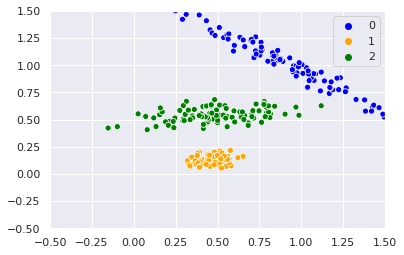

In [25]:
# Generate some data from those distributions:

num_points = 100
data1 = np.random.multivariate_normal(mu1,cov1,size=num_points)
data2 = np.random.multivariate_normal(mu2,cov2,size=num_points)
data3 = np.random.multivariate_normal(mu3,cov3,size=num_points)
data_all = np.concatenate((data1,data2,data3))
color_data = np.concatenate((np.repeat(0,num_points),np.repeat(1,num_points),np.repeat(2,num_points)))
ax = sns.scatterplot(x   = data_all.transpose()[0],
                     y   = data_all.transpose()[1],
                     hue = color_data,
                     palette = palette)
set_bounds(ax)

In [26]:
# Learn parameters W from the data

X = np.concatenate((np.ones(3*num_points).reshape(-1,1),data_all),axis=1)
T = np.repeat([[1,0,0],[0,1,0],[0,0,1]],[num_points,num_points,num_points],axis=0)

W = np.linalg.solve(X.transpose() @ X, X.transpose() @ T)

Defining $\vec{y}=[1\ \vec{x}]W$ (row vectors) for any particular input $\vec{x}$, the class prediction for the input $\vec{x}$ will be the index $i\in\{1,2,3\}$ such that $y_i$ is the biggest of the entries $y_1,y_2,y_3$ of $\vec{y}$.

Then where are the decision boundaries? The boundary between predicting class $1$ and predicting class $2$ would be the set of points $\vec{x}$ such that $y_1=y_2$ and $y_1,y_2>y_3$. Since $y_1+y_2+y_3=1$, we can rephrase the condition as follows: _The boundary between predicting class $1$ and predicting class $2$ is the set of points $\vec{x}$ such that $y_1=y_2$ and $y_1>\frac{1}{3}$._

Thus the decision boundaries are _rays_ in the plane, with their common endpoint at the $\vec{x}$ that makes $y_1=y_2=y_3=\frac{1}{3}$.

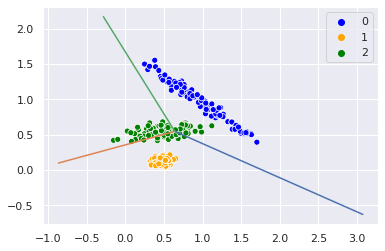

In [27]:
# This is a way I came up with for finding a couple of points on a ray,
# the ray corresponding to the given columns of the matrix W
w1,w2,w3 = W.transpose()
def ray_points(wi,wj):
    a = np.array([[1,0,0],wi-wj,wi])
    b = np.array([[1,0,1./3.],[1,0,1]]).transpose()
    soln = np.linalg.solve(a,b)
    # return two points on the ray, as the columns of a 2x2 matrix
    return soln[1:]

ax = sns.scatterplot(x   = data_all.transpose()[0],
                     y   = data_all.transpose()[1],
                     hue = color_data,
                     palette = palette)
for pts in [ray_points(w1,w2),ray_points(w2,w3),ray_points(w3,w1)]:
    ax.plot(pts[0],pts[1])

Next: In what sense is least squares "assuming" that the data distribution is gaussian? This is a comment from the textbook that I'm not following.